**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_numerical -p 8888:8888 -p 8786:8786 -p 8787:8787 -d palmoreck/jupyterlab_numerical:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_numerical
```


Documentación de la imagen de docker `palmoreck/jupyterlab_numerical:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/numerical).

---

Nota generada a partir de la [liga1](https://www.dropbox.com/s/jfrxanjls8kndjp/Diferenciacion_e_Integracion.pdf?dl=0) y [liga2](https://www.dropbox.com/s/k3y7h9yn5d3yf3t/Integracion_por_Monte_Carlo.pdf?dl=0).

Los métodos revisados en esta nota de integración numérica serán utilizados más adelante para revisión de herramientas en Python para **perfilamiento de código: uso de cpu y memoria**. También serán referidos en el capítulo de **cómputo en paralelo**.

In [1]:
import math
import numpy as np

from scipy.integrate import quad
import matplotlib.pyplot as plt

# Integración Numérica

En lo siguiente consideramos que las funciones del integrando están en $\mathcal{C}^2$ en el conjunto de integración (ver final de nota [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb) para definición de $\mathcal{C}^2$).

Las reglas o métodos por cuadratura nos ayudan a aproximar integrales con sumas de la forma:

$$\displaystyle \int_a^bf(x)dx \approx \displaystyle \sum_{i=0}^nw_if(x_i)$$

donde: $w_i$ es el peso para el nodo $x_i$, $f$ se llama integrando y $[a,b]$ intervalo de integración. Los valores $f(x_i)$ se asumen conocidos.

Todas las reglas o métodos por cuadratura se obtienen con interpoladores polinomiales del integrando (por ejemplo usando la representación de Lagrange) o también con el teorema Taylor (ver nota [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb) para éste teorema).

Se realizan aproximaciones numéricas por:
* Desconocimiento de la función en todo el intervalo $[a,b]$ y sólo se conoce en los nodos su valor.
* Inexistencia de antiderivada o primitiva del integrando. Por ejemplo: 

$$\displaystyle \int_a^be^{-\frac{x^2}{2}}dx$$ con $a,b$ números reales.

Dependiendo de la ubicación de los nodos y pesos es el método de cuadratura que resulta:

* Newton-Cotes si los nodos y pesos son equidistantes como la regla del rectángulo, trapecio y Simpson (con el teorema de Taylor o interpolación es posible obtener tales fórmulas).
* Cuadratura Gaussiana si se desea obtener reglas o fórmulas que tengan la mayor exactitud posible. Ejemplos de este tipo de cuadratura se tiene la regla por cuadratura Gauss-Legendre en [-1,1] o Gauss-Hermite para el caso de integrales en $[-\infty, \infty]$ con integrando $e^{-x^2}f(x)$.

**Comentario:**

Los métodos de integración numérica por Newton-Cotes o cuadratura Gaussiana pueden extenderse a más dimensiones, sin embargo incurren en lo que se conoce como la **maldición de la dimensionalidad** que para el caso de integración numérica consiste en la gran cantidad de evaluaciones que deben realizarse de la función del integrando para tener una exactitud pequeña, por ejemplo con un número de nodos igual a $10^4$, una distancia entre ellos de $.1$ y una integral en $4$ dimensiones para la regla por Newton Cotes del rectángulo, se obtiene una exactitud de $2$ dígitos. Como alternativa a los métodos por cuadratura anteriores para las integrales de más dimensiones se tienen los **métodos de integración por el método Monte Carlo** que generan aproximaciones con una exactitud moderada (del orden de $\mathcal{O}(n^{-1/2})$ con $n$ número de nodos) para un número de puntos moderado independiente de la dimensión.


## Newton-Cotes

Si el conjunto de nodos $x_i, i=0,1,\dots,n$ cumple $x_{i+1}-x_i=h, \forall i=0,1,\dots,n-1$ con $h$ (espaciado) constante y se aproxima la función del integrando $f$ con un polinomio en $(x_i,f(x_i)) \forall i=0,1,\dots,n$ entonces se tiene un método de integración numérica por Newton-Cotes (o reglas o fórmulas por Newton-Cotes).

<img src="https://dl.dropboxusercontent.com/s/baf7eauuwm347zk/integracion_numerica.png?dl=0" heigth="500" width="500">

En el dibujo: a),b) y c) se integra numéricamente por Newton-Cotes. d) es por cuadratura Gaussiana.


**Comentario:** si la fórmula por Newton-Cotes involucra el valor de la función en los extremos se llama cerrada, si no los involucra se les llama abiertas. En el dibujo d) es abierta.

El dibujo anterior muestra que puede subdivirse el intervalo de integración en una mayor cantidad de subintervalos, lo cual para la función $f$ mostrada es benéfico pues se tiene mejor aproximación (en la práctica esto será bueno? recuérdese los errores de redondeo de la nota [1.2.Sistema_de_punto_flotante](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.2.Sistema_de_punto_flotante.ipynb)). Los métodos que utilizan la idea anterior de dividir en subintervalos se les conoce como **métodos de integración numérica compuestos** en contraste con los simples. 

**Comentario:** Para las reglas compuestas se divide el intervalo $[a,b]$ en $n$ subinteralos $[x_{i-1},x_i], i=1,\dots,n$ con $x_0=a<x_1<\dots<x_{n-1}<x_n=b$ y se considera una partición regular, esto es: $x_i-x_{i-1}=\hat{h}$ con $\hat{h}=\frac{h}{n}$ y $h=b-a$. En este contexto se realiza la aproximación:

$$\displaystyle \int_a^bf(x)dx = \sum_{i=1}^n\int_{x_{i-1}}^{x_i}f(x)dx.$$

Para las siguientes reglas se considerará la función $f(x)=e^{-x^2}$ la cual tiene una forma:

In [2]:
f=lambda x: np.exp(-x**2)

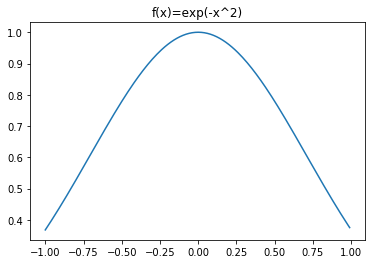

In [3]:
x=np.arange(-1,1,.01)
plt.plot(x,f(x))
plt.title('f(x)=exp(-x^2)')
plt.show()

El valor de la integral $\int_0^1e^{-x^2}dx$ es:

In [4]:
obj, err = quad(f, 0, 1)

In [5]:
(obj,err)

(0.7468241328124271, 8.291413475940725e-15)

**Obs:** el segundo valor regresado `err`, es una cota superior del error.

### Regla simple del rectángulo

Denotaremos a esta regla como $Rf$. En este caso se aproxima el integrando $f$ por un polinomio de grado **cero** con nodo en $x_1 = \frac{a+b}{2}$. Entonces: 

$$\displaystyle \int_a^bf(x)dx \approx \int_a^bf(x_1)dx = (b-a)f(x_1)=(b-a)f\left( \frac{a+b}{2} \right ) = hf(x_1)$$

con $h=b-a, x_1=\frac{a+b}{2}$.


<img src="https://dl.dropboxusercontent.com/s/mzlmnvgnltqamz3/rectangulo_simple.png?dl=0" heigth="200" width="200">


**Ejemplo de implantación de regla simple de rectángulo: usando math**

Utilizar la regla simple del rectángulo para aproximar la integral $\displaystyle \int_0^1e^{-x^2}dx$.

In [6]:
f=lambda x: math.exp(-x**2) #using math library

In [7]:
def Rf(f,a,b):
    nodo=a+(b-a)/2.0 #mid point formula to minimize rounding errors
    return f(nodo) #polinomio de grado cero

In [8]:
Rf(f,0,1)

0.7788007830714049

### Regla compuesta del rectángulo

En cada subintervalo se aplica la regla simple $Rf$, esto es:

$$\displaystyle \int_{x_{i-1}}^{x_i}f(x)dx \approx R_i(f) \forall i=1,\dots,n.$$

De forma sencilla se puede ver que la regla compuesta del rectángulo $R_c(f)$ se escribe:

$$R_c(f) = \displaystyle \sum_{i=1}^n(x_i-x_{i-1})f\left( \frac{x_i+x_{i-1}}{2}\right) = \frac{h}{n}\sum_{i=1}^nf\left( \frac{x_i+x_{i-1}}{2}\right)$$

con $h=b-a$ y $n$ número de subintervalos.

<img src="https://dl.dropboxusercontent.com/s/j2wmiyoms7gxrzp/rectangulo_compuesto.png?dl=0" heigth="200" width="200">


**Nota:** Los nodos para el caso del rectángulo se obtienen con la fórmula: $x_i = a +(i+\frac{1}{2})\hat{h}, \forall i=0,\dots,n-1, \hat{h}=\frac{h}{n}$.

**Ejemplo de implantación de regla compuesta de rectángulo: usando math**

Utilizar la regla compuesta del rectángulo para aproximar la integral $\int_0^1e^{-x^2}dx$.

In [9]:
f=lambda x: math.exp(-x**2) #using math library

In [10]:
def Rcf(f,a,b,n): #Rcf: rectángulo compuesto para f
    """
    Compute numerical approximation using rectangle or mid-point method in 
    an interval.
    Nodes are generated via formula: x_i = a+(i+1/2)h_hat for i=0,1,...,n-1 and h_hat=(b-a)/n
    Args:
        f (lambda expression): lambda expression of integrand
        a (int): left point of interval
        b (int): right point of interval
        n (int): number of subintervals
    Returns:
        Rcf (float) 
    """
    h_hat=(b-a)/n
    nodes=[a+(i+1/2)*h_hat for i in range(0,n)]
    sum_res=0
    for node in nodes:
        sum_res=sum_res+f(node)
    return h_hat*sum_res 

In [11]:
aprox_1=Rcf(f,0,1,1)
aprox_1

0.7788007830714049

In [12]:
aprox_2=Rcf(f,0,1,2)
aprox_2

0.7545979437721995

In [13]:
aprox_2=Rcf(f,0,1,2)
aprox_2

0.7545979437721995

In [14]:
aprox_3=Rcf(f,0,1,10**3)
aprox_3

0.746824163469049

Y se puede evaluar el error de aproximación con el error relativo:

In [15]:
def err_relativo(aprox, obj):
    return math.fabs(aprox-obj)/math.fabs(obj) #obsérvese el uso de la librería math

In [16]:
obj, err = quad(f, 0, 1)
(err_relativo(aprox_1,obj), err_relativo(aprox_2,obj), err_relativo(aprox_3,obj))

(0.04281684114646715, 0.010409158754012628, 4.1049318789768585e-08)

**Pregunta: será el método del rectángulo un método estable numéricamente bajo el redondeo?** Ver nota [1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo.ipynb) para definición de estabilidad numérica de un algoritmo.

In [17]:
aprox_4=Rcf(f,0,1,10**5)
aprox_4

0.7468241328154887

In [18]:
err_relativo(aprox_4,obj)

4.099426997862257e-12

Al menos para este ejemplo con $10^5$ nodos parece ser numéricamente estable... 

### Regla compuesta del trapecio

<img src="https://dl.dropboxusercontent.com/s/4dl2btndrftdorp/trapecio_compuesto.png?dl=0" heigth="200" width="200">


En cada subintervalo se aplica la regla simple $Tf$, esto es:

$$\displaystyle \int_{x_{i-1}}^{x_i}f(x)dx \approx T_i(f) \forall i=1,\dots,n.$$

Con $T_i(f) = \frac{(x_i-x_{i-1})}{2}(f(x_i)+f(x_{i-1}))$ para $i=1,\dots,n$.

De forma sencilla se puede ver que la regla compuesta del trapecio $T_c(f)$ se escribe como:

$$T_c(f) = \displaystyle \frac{h}{2n}\left[f(x_0)+f(x_n)+2\displaystyle\sum_{i=1}^{n-1}f(x_i)\right]$$

con $h=b-a$ y $n$ número de subintervalos.

**Nota:** Los nodos para el caso del trapecio se obtienen con la fórmula: $x_i = a +i\hat{h}, \forall i=1,\dots,n, \hat{h}=\frac{h}{n}$.

**Ejemplo de implementación de regla compuesta del trapecio: usando numpy**

Con la regla compuesta del trapecio se aproximará la integral $\int_0^1e^{-x^2}dx$. Se calculará el error relativo y  graficará $n$ vs Error relativo para $n=1,10,100,1000,10000$.

In [19]:
f=lambda x: np.exp(-x**2) #using numpy library

In [20]:
def Tcf(n,f,a,b): #Tcf: trapecio compuesto para f
    """
    Compute numerical approximation using trapezoidal rule in 
    an interval.
    Nodes are generated via numpy
    Args:
        f (lambda expression): lambda expression of integrand
        a (int): left point of interval
        b (int): right point of interval
        n (int): number of subintervals
    Returns:
        Tcf (float) 
    """
    h=b-a
    nodes=np.linspace(a,b,n+1)
    sum_res=sum(f(nodes[1:-1]))
    return h/(2*n)*(f(nodes[0])+f(nodes[-1])+2*sum_res)

Graficamos:

In [21]:
numb_of_subintervals=(1,10,100,1000,10000)

In [22]:
approx = np.array([Tcf(n,f,0,1) for n in numb_of_subintervals])

In [23]:
def err_relativo(aprox, obj):
    return np.abs(aprox-obj)/np.abs(obj) #obsérvese el uso de la librería numpy

In [24]:
err_relativo_res = err_relativo(approx,obj)

In [25]:
err_relativo_res

array([8.42024373e-02, 8.21259857e-04, 8.20989064e-06, 8.20986364e-08,
       8.20987410e-10])

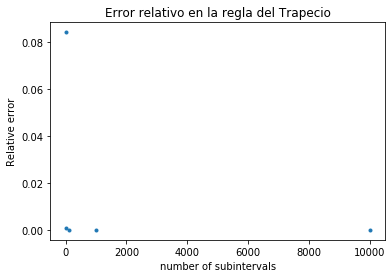

In [26]:
plt.plot(numb_of_subintervals,err_relativo_res,'.')
plt.xlabel('number of subintervals')
plt.ylabel('Relative error')
plt.title('Error relativo en la regla del Trapecio')
plt.show()

Si no nos interesa el valor de los errores relativos y sólo la gráfica podemos utilizar la siguiente opción:

In [27]:
from functools import partial

Ver [functools.partial](https://docs.python.org/2/library/functools.html#functools.partial) para documentación, [liga](https://stackoverflow.com/questions/15331726/how-does-functools-partial-do-what-it-does) para una explicación de `partial` y [liga2](https://stackoverflow.com/questions/10834960/how-to-do-multiple-arguments-to-map-function-where-one-remains-the-same-in-pytho), [liga3](https://stackoverflow.com/questions/47859209/how-to-map-over-a-function-with-multiple-arguments-in-python) para ejemplos de uso.

In [28]:
approx=map(partial(Tcf,f=f,a=0,b=1),numb_of_subintervals) #map regresa un iterator

In [29]:
def err_relativo(aprox_map, obj):
    for ap in aprox_map:
        yield math.fabs(ap-obj)/math.fabs(obj) #obsérvese el uso de la librería math

In [30]:
err_relativo_res = err_relativo(approx,obj)

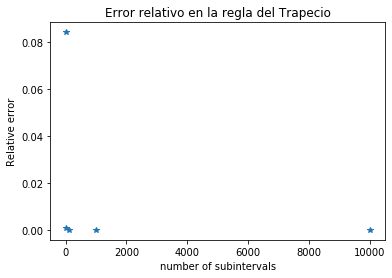

In [31]:
plt.plot(numb_of_subintervals,list(err_relativo_res),'*')
plt.xlabel('number of subintervals')
plt.ylabel('Relative error')
plt.title('Error relativo en la regla del Trapecio')
plt.show()

**usando scatter:**

In [32]:
approx=map(partial(Tcf,f=f,a=0,b=1),numb_of_subintervals) #map regresa un iterator

In [33]:
err_relativo_res = err_relativo(approx,obj)

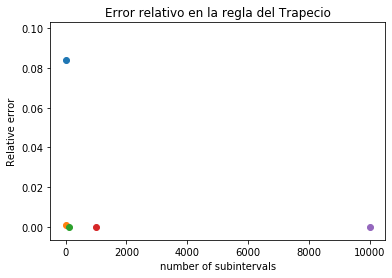

In [34]:
[plt.scatter(n,err_rel) for n,err_rel in zip(numb_of_subintervals,err_relativo_res)]
plt.xlabel('number of subintervals')
plt.ylabel('Relative error')
plt.title('Error relativo en la regla del Trapecio')
plt.show()

### Regla compuesta de Simpson

<img src="https://dl.dropboxusercontent.com/s/8rx32vdtulpdflm/Simpson_compuesto.png?dl=0" heigth="200" width="200">


En cada subintervalo se aplica la regla simple $Sf$, esto es:

$$\displaystyle \int_{x_{i-1}}^{x_i}f(x)dx \approx S_i(f) \forall i=1,\dots,n$$

con $n$ par y $S_i(f) = \frac{h}{6}\left[f(x_{2i}+f(x_{2i-2})+4f(x_{2i-1})\right]$ para $i=1,\dots,\frac{n}{2}$..

De forma sencilla se puede ver que la regla compuesta del trapecio $S_c(f)$ se escribe como:

$$S_c(f) = \displaystyle \frac{h}{3n} \left [ f(x_0) + f(x_n) + 2 \sum_{i=1}^{\frac{n}{2}-1}f(x_{2i}) + 4 \sum_{i=1}^{\frac{n}{2}}f(x_{2i-1})\right ] $$

con $h=b-a$ y $n$ número de subintervalos (par).

**Nota:** Los nodos para el caso de Simpson se obtienen con la fórmula: $x_i = a +\frac{i}{2}\hat{h}, \forall i=1,\dots,n, \hat{h}=\frac{h}{n}$.

**Ejercicio: implementar la regla compuesta de Simpson para aproximar la integral $\int_0^1e^{-x^2}dx$. Calcular error relativo y realizar una gráfica de $n$ vs Error relativo para $n=1,10,100,1000,10000$ utilizando numpy e iterators.**

La forma de los errores de las reglas del rectángulo, trapecio y Simpson se pueden obtener con interpolación o con el teorema de Taylor. Ver [liga](https://www.dropbox.com/s/jfrxanjls8kndjp/Diferenciacion_e_Integracion.pdf?dl=0) para detalles y [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb) para el teorema. Suponiendo que $f$ cumple con condiciones sobre sus derivadas, tales errores son:


$$\text{Err}Rc(f) = \frac{b-a}{6}f^{(2)}(\xi_r)\hat{h}^2, \xi_r \in [a,b]$$

$$\text{Err}Tc(f)=-\frac{b-a}{12}f^{(2)}(\xi_t)\hat{h}^2, \xi_t \in [a,b]$$

$$\text{Err}Sc(f)=-\frac{b-a}{180}f^{(4)}(\xi_S)\hat{h}^4, \xi_S \in [a,b].$$

# Integración por el método de Monte Carlo

Los métodos de integración numérica por Monte Carlo son similares a los métodos por cuadratura en el sentido que se eligen puntos en los que se evaluará el integrando para sumar sus valores. La diferencia esencial con los métodos por cuadratura es que en el método de integración por Monte Carlo los puntos son seleccionados de una forma *aleatoria* (de hecho es pseudo-aleatoria pues se generan con un programa de computadora) en lugar de generarse con una fórmula.

**Problema:** Aproximar numéricamente la integral $\displaystyle \int_{\Omega}f(x)dx$ para $x \in \mathbb{R}^N, \Omega \subseteq \mathbb{R}^N, f: \mathbb{R}^N \rightarrow \mathbb{R}$ función tal que la integral esté bien definida en $\Omega$.

Por ejemplo para $N=2:$

<img src="https://dl.dropboxusercontent.com/s/xktwjmgbf8aiekw/integral_2_dimensiones.png?dl=0" heigth="500" width="500">


Para resolver el problema anterior con $\Omega$ un rectángulo, podemos utilizar las reglas por cuadratura por Newton-Cotes o cuadratura Gaussiana en una dimensión manteniendo fija la otra dimensión. Sin embargo considérese la siguiente situación:

La regla del rectángulo (o del punto medio) y del trapecio tienen un error de orden $\mathcal{O}(h^2)$ independientemente de si se está aproximando integrales de una o más dimensiones. Supóngase que se utilizan $n$ nodos para tener un valor de espaciado igual a $h$, entonces para $N$ dimensiones se requerirían $P=n^N$ evaluaciones del integrando, o bien, si se tiene un valor de $P$ igual a $10, 000$ y $N=4$ dimensiones el error sería del orden $\mathcal{O}(P^{-2/N})$ lo que implicaría un valor de $h=.1$ para aproximadamente sólo **dos dígitos** correctos en la aproximación (para el enunciado anterior recuérdese que $h$ es proporcional a $n^{-1}$ y $n$ = $P^{1/N}$). Este esfuerzo enorme de evaluar $P$ veces el integrando para una exactitud pequeña se debe al problema de generar puntos para *llenar* un espacio $N$-dimensional y se conoce con el nombre de la maldición de la dimensionalidad, **the curse of dimensionality**.

Una opción para resolver la situación anterior si no se desea una exactitud grande (por ejemplo con una precisión de $10^{-4}$ o $4$ dígitos es suficiente) es con el método de integración por Monte Carlo (tal nombre por el uso de números aleatorios). La integración por el método de Monte Carlo está basada en la interpretación geométrica de las integrales: calcular la integral del problema inicial implica calcular el **hipervolumen** de $\Omega$.

**Ejemplo:**

Supóngase que se desea aproximar el área de un círculo centrado en el origen de radio igual a $1$:

<img src="https://dl.dropboxusercontent.com/s/xmtcxw3wntfxuau/monte_carlo_1.png?dl=0" heigth="300" width="300">


entonces el área de este círculo es $\pi r^2 = \pi$.

Para lo anterior **encerramos** al círculo con un cuadrado de lado $2$:

<img src="https://dl.dropboxusercontent.com/s/igsn57vuahem0il/monte_carlo_2.png?dl=0" heigth="200" width="200">

Si tenemos $n$ puntos en el cuadrado:

<img src="https://dl.dropboxusercontent.com/s/a4krdneo0jaerqz/monte_carlo_3.png?dl=0" heigth="200" width="200">


y consideramos los $m$ puntos que están dentro del círculo:

<img src="https://dl.dropboxusercontent.com/s/pr4c5e57r4fawdt/monte_carlo_4.png?dl=0" heigth="200" width="200">

Entonces: $\frac{\text{Área del círculo}}{\text{Área del cuadrado}} \approx \frac{m}{n}$ y se tiene: Área del círculo $\approx$Área del cuadrado$\frac{m}{n}$ y si $n$ crece entonces la aproximación es mejor.

prueba numérica:

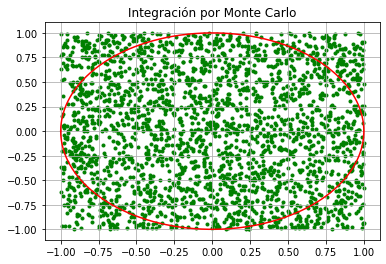

In [35]:
density_p=int(2.5*10**3)
x_p=np.random.uniform(-1,1,(density_p,2))
plt.scatter(x_p[:,0],x_p[:,1],marker='.',color='g')
density=1e-5
x=np.arange(-1,1,density)
y1=np.sqrt(1-x**2)
y2=-np.sqrt(1-x**2)
plt.plot(x,y1,'r',x,y2,'r')
plt.title('Integración por Monte Carlo')
plt.grid()
plt.show()

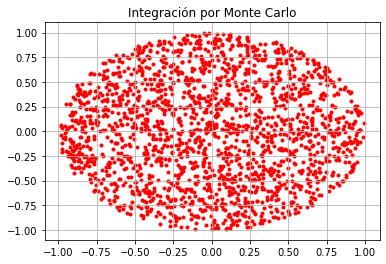

In [36]:
f=lambda x: np.sqrt(x[:,0]**2 + x[:,1]**2) #definición de norma2
ind=f(x_p)<=1
x_p_subset=x_p[ind]
plt.scatter(x_p_subset[:,0],x_p_subset[:,1],marker='.',color='r')
plt.title('Integración por Monte Carlo')
plt.grid()
plt.show()

Área del círculo es aproximadamente:

In [37]:
Area_cuadrado=4
Area_cuadrado*len(x_p_subset)/len(x_p)

3.0832

Si aumentamos el número de puntos...

In [38]:
density_p=int(10**4)
x_p=np.random.uniform(-1,1,(density_p,2))
ind=f(x_p)<=1
x_p_subset=x_p[ind]
Area_cuadrado*len(x_p_subset)/len(x_p)

3.1024

In [39]:
density_p=int(10**5)
x_p=np.random.uniform(-1,1,(density_p,2))
ind=f(x_p)<=1
x_p_subset=x_p[ind]
Area_cuadrado*len(x_p_subset)/len(x_p)

3.14668

**Comentarios:**

* El método de Monte Carlo revisado en el ejemplo anterior nos indica que debemos encerrar a la región de integración $\Omega$. Por ejemplo para una región $\Omega$ más general:

<img src="https://dl.dropboxusercontent.com/s/ke6hngwue3ovpaz/monte_carlo_5.png?dl=0" heigth="300" width="300">


entonces la integración por el método de Monte Carlo será:

$$\displaystyle \int_\Omega f d\Omega \approx V \overline{f}$$

donde: $V$ es el hipervolumen de $\Omega_E$ que encierra a $\Omega$, esto es $\Omega \subseteq \Omega_E$, $\{x_1,\dots,x_n\}$ es un conjunto de puntos distribuidos uniformemente en $\Omega_E$ y $\overline{f}=\frac{1}{n}\displaystyle \sum_{i=1}^nf(x_i)$

* Consideramos $\overline{f}$ pues $\displaystyle \sum_{i=1}^nf(x_i)$ representa el valor de $m$ si pensamos a $f$ como una restricción que deben cumplir los $n$ puntos en el ejemplo de aproximación al área del círculo: Área del círculo $\approx$Área del cuadrado$\frac{m}{n}$ (en este caso Área del cuadrado es el hipervolumen $V$).

* Algunas características para regiones que encierren a $\Omega$ es que:

    * Sea sencillo generar números aleatorios uniformes.
    * Sea sencillo obtener su hipervolumen.

**Ejemplos:** aproximar las siguientes integrales:

In [40]:
density_p=int(10**4)

* $\displaystyle \int_0^1\frac{4}{1+x^2}dx = \pi$

In [41]:
f=lambda x: 4/(1+x**2)
x_p=np.random.uniform(0,1,density_p)
obj=math.pi
a=0
b=1
vol=b-a
approx=vol*np.mean(f(x_p))
err_rel=lambda ap,ob: math.fabs(ap-ob)/math.fabs(ob)
"error relativo: {:0.4e}".format(err_rel(approx,obj))

'error relativo: 1.9269e-03'

* $\displaystyle \int_1^2 \frac{1}{x}dx = \log{2}$.

In [42]:
f=lambda x: 1/x
x_p=np.random.uniform(1,2,density_p)
obj=math.log(2)
a=1
b=2
vol=b-a
approx=vol*np.mean(f(x_p))
"error relativo: {:0.4e}".format(err_rel(approx,obj))

'error relativo: 1.3407e-03'

* $\displaystyle \int_{-1}^1 \int_0^1x^2+y^2dxdy = \frac{4}{3}$. 

In [43]:
f=lambda x,y:x**2+y**2
a1=-1
b1=1
a2=0
b2=1
x_p=np.random.uniform(a1,b1,density_p)
y_p=np.random.uniform(a2,b2,density_p)
obj=4/3
vol=(b1-a1)*(b2-a2)
approx=vol*np.mean(f(x_p,y_p))
"error relativo: {:0.4e}".format(err_rel(approx,obj))

'error relativo: 9.1573e-03'

* $\displaystyle \int_0^{\frac{\pi}{2}} \int_0^{\frac{\pi}{2}}\cos(x)\sin(y)dxdy=1$.

In [44]:
f=lambda x,y:np.cos(x)*np.sin(y)
a1=0
b1=math.pi/2
a2=0
b2=math.pi/2
x_p=np.random.uniform(a1,b1,density_p)
y_p=np.random.uniform(a2,b2,density_p)
obj=1
vol=(b1-a1)*(b2-a2)
approx=vol*np.mean(f(x_p,y_p))
"error relativo: {:0.4e}".format(err_rel(approx,obj))

'error relativo: 3.5390e-03'

* $\displaystyle \int_0^1\int_{\frac{-1}{2}}^0\int_0^{\frac{1}{3}}(x+2y+3z)^2dxdydz =\frac{1}{12}$.

In [45]:
f=lambda x,y,z:(x+2*y+3*z)**2
a1=0
b1=1
a2=-1/2
b2=0
a3=0
b3=1/3
x_p=np.random.uniform(a1,b1,density_p)
y_p=np.random.uniform(a2,b2,density_p)
z_p=np.random.uniform(a3,b3,density_p)
obj=1/12
vol=(b1-a1)*(b2-a2)*(b3-a3)
approx=vol*np.mean(f(x_p,y_p,z_p))
"error relativo: {:0.4e}".format(err_rel(approx,obj))

'error relativo: 3.5333e-03'

## Cuál es el error en la aproximación por el método de integración por Monte Carlo?

Para obtener la expresión del error en esta aproximación supóngase que $x_1, x_2,\dots x_n$ son variables aleatorias independientes uniformemente distribuidas. Entonces:

$$\text{Err}(\overline{f})=\sqrt{\text{Var}(\overline{f})}=\sqrt{\text{Var}\left( \frac{1}{n} \displaystyle \sum_{i=1}^nf(x_i)\right)}=\dots=\sqrt{\frac{\text{Var}(f(x))}{n}}$$

con $x$ variable aleatoria uniformemente distribuida.

Un estimador de $\text{Var}(f(x))$ es: $\frac{1}{n}\displaystyle \sum_{i=1}^n(f(x_i)-\overline{f})^2=\overline{f^2}-\overline{f}^2$ por lo que $\hat{\text{Err}}(\overline{f}) = \sqrt{\frac{\overline{f^2}-\overline{f}^2}{n}}$.

Se tiene entonces: 

$$\displaystyle \int_\Omega f d\Omega \approx V(\overline{f} \pm \text{Err}(\overline{f})) \approx V(\overline{f} \pm \hat{\text{Err}}(\overline{f}))=V\overline{f} \pm V\sqrt{\frac{\overline{f^2}-\overline{f}^2}{n}}$$

**Ejemplo:**

Para el ejemplo anterior $\displaystyle \int_0^1\frac{4}{1+x^2}dx = \pi$ se tiene:

In [46]:
f=lambda x: 4/(1+x**2)
x_p=np.random.uniform(0,1,density_p)
obj=math.pi
a=0
b=1
vol=b-a
approx=vol*np.mean(f(x_p))
err_rel=lambda ap,ob: math.fabs(ap-ob)/math.fabs(ob)
"error relativo: {:0.4e}".format(err_rel(approx,obj))

'error relativo: 1.4883e-03'

In [47]:
error_est = math.sqrt(sum((f(x_p)-approx)**2)/density_p)

In [48]:
error_est

0.6436019228650124

intervalo:

In [49]:
(approx-(b-a)*error_est, approx+(b-a)*error_est)

(2.4933151535819356, 3.78051899931196)

**Ejercicios:** Aproximar, reportar errores relativos e intervalo de estimación en una tabla:

* $\displaystyle \int_0^1\int_0^1\sqrt{x+y}dydx=\frac{2}{3}\left(\frac{2}{5}2^{5/2}-\frac{4}{5}\right)$.

* $\displaystyle \int_D \int \sqrt{x+y}dydx=8\frac{\sqrt{2}}{15}$ donde: $D=\{(x,y) \in \mathbb{R}^2 | 0 \leq x \leq 1, -x \leq y \leq x\}$.

* $\displaystyle \int_D \int \exp{(x^2+y^2)}dydx = \pi(e^9-1)$ donde $D=\{(x,y) \in \mathbb{R}^2 | x^2+y^2 \leq 9\}$.

* $\displaystyle \int_0^2 \int_{-1}^1 \int_0^1 (2x+3y+z)dzdydx = 10$.

**Comentarios:**

* Los signos $\pm$ en el error de aproximación **no** representan una cota rigurosa, es una desviación estándar.

* A diferencia de la aproximación por las reglas por cuadratura tenemos una precisión con $n$ puntos independientemente de la dimensión $N$.

* Si $N \rightarrow \infty$ entonces $\hat{\text{Err}}(\overline{f}) = \mathcal{O}\left(\frac{1}{\sqrt{n}} \right)$ por lo que para ganar un decimal extra de precisión en la integración por el método de Monte Carlo se requiere incrementar el número de puntos por un factor de $10^2$.

**Obs:** obsérvese que si $f$ es constante entonces $\hat{\text{Err}}(\overline{f})=0$. Esto implica que si $f$ es casi constante y $\Omega_E$ encierra muy bien a $\Omega$ entonces se tendrá una estimación muy precisa de $\displaystyle \int_\Omega f d\Omega$, por esto en la integración por el método de Monte Carlo se realizan cambios de variable de modo que transformen a $f$ en aproximadamente constante y que esto resulte además en regiones $\Omega_E$ que encierren a $\Omega$ casi de manera exacta (y que además sea sencillo generar números pseudo aleatorios en ellas!).

**Comentario:**

La integración por el método de Monte Carlo se utiliza para aproximar características de variables aleatorias continuas. Por ejemplo, si $x$ es variable aleatoria continua, entonces su media está dada por:

$$E_f[h(X)] = \displaystyle \int_{S_X}h(x)f(x)dx$$

donde $f$ es función de densidad de $X$, $S_X$ es el soporte de $X$ y $h$ es una transformación. Entonces:



$$E_f[h(X)] \approx \frac{1}{n} \displaystyle \sum_{i=1}^nh(x_i)=\overline{h}_n$$

con $\{x_1,x_2,\dots,x_n\}$ muestra de $f$. Y por la ley de los grandes números se tiene:

$$\overline{h}_n \xrightarrow{n \rightarrow \infty} E_f[h(X)]$$ con **convergencia casi segura**. Aún más: si $E_f[h^2(X)] < \infty$ entonces el error de aproximación  de $\overline{h}_n$ es del orden $\mathcal{O}\left(\frac{1}{\sqrt{n}} \right)$ y una estimación de este error es: $\hat{\text{Err}}(\overline{h}) = \sqrt{\frac{\overline{h^2}-\overline{h}^2}{n}}$. Por el teorema del límite central:

$$\frac{\overline{h}_n-E_f[h(X)]}{\hat{\text{Err}}(\overline{h})} \xrightarrow{n \rightarrow \infty} N(0,1)$$

con $N(0,1)$ una distribución Normal con $\mu=0,\sigma=1$ $\therefore$ si $n \rightarrow \infty$ un intervalo de confianza al $95\%$ para $E_f[h(X)]$ es: $(\overline{h}_n \pm z_{.975} \hat{\text{Err}}(\overline{h}))$.

**Obs:** uno de los pasos complicados en el desarrollo anterior es obtener una muestra de $f$ que para el caso de variables continuas se puede utilizar el teorema de transformación inversa o integral de probabilidad.

**Ejercicios**

1. Resuelve los ejercicios y preguntas de la nota.


**Referencias**

1. R. L. Burden, J. D. Faires, Numerical Analysis, Brooks/Cole Cengage Learning, 2005.

2. M. T. Heath, Scientific Computing. An Introductory Survey, McGraw-Hill, 2002.

3. Nota [1.2.Sistema_de_punto_flotante](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.2.Sistema_de_punto_flotante.ipynb))

4. Nota [1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo.ipynb)

5. [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb)